In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_PATH="/content/drive/MyDrive/taxi_data_subset.csv"

In [14]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from collections import Counter
from geopy.distance import geodesic

In [ ]:
df = pd.read_csv(data_PATH)

In [ ]:
df_info = df.info()
df_head = df.head()

missing_values = df.isnull().sum()

df_description = df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     10000 non-null  int64  
 1   DriveNo        10000 non-null  int64  
 2   Date and Time  10000 non-null  object 
 3   Latitude       10000 non-null  float64
 4   Longitude      10000 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 390.8+ KB


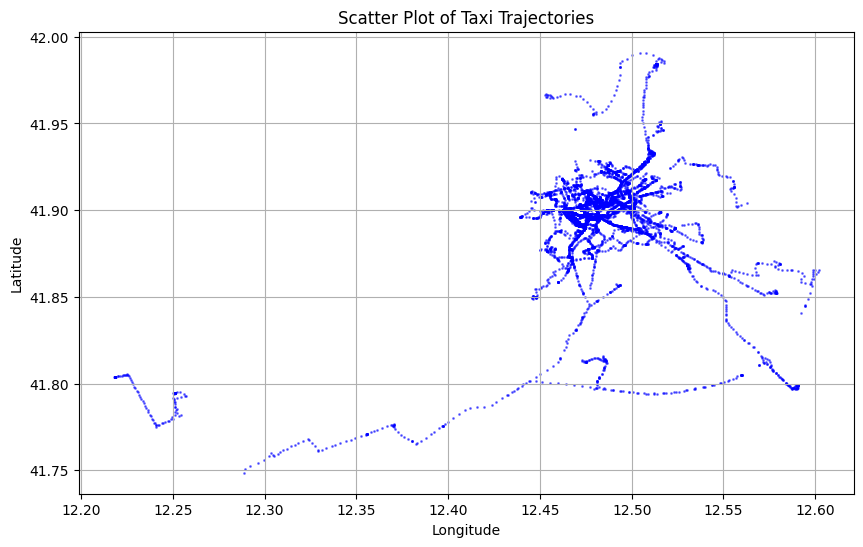

In [ ]:
# Visualizing Scatter Plot (All Points)
plt.figure(figsize=(10, 6))
plt.scatter(df['Longitude'], df['Latitude'], s=1, c='blue', alpha=0.5)
plt.title('Scatter Plot of Taxi Trajectories')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

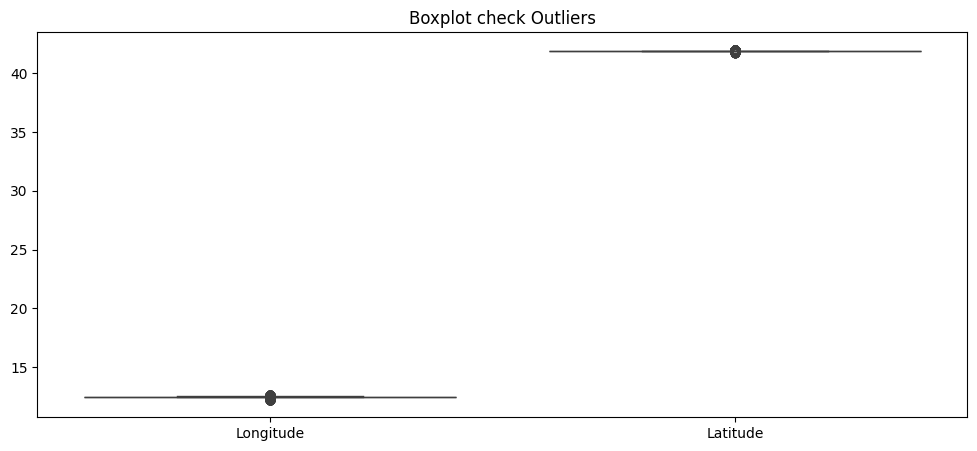

(None,
    Unnamed: 0  DriveNo                  Date and Time   Latitude  Longitude
 0           1      156  2014-02-01 00:00:00.739166+01  41.883672  12.487778
 1           2      187  2014-02-01 00:00:01.148457+01  41.928543  12.469037
 2           3      297  2014-02-01 00:00:01.220066+01  41.891069  12.492705
 3           4       89  2014-02-01 00:00:01.470854+01  41.793177  12.432122
 4           5       79  2014-02-01 00:00:01.631136+01  41.900275  12.462746,
 Unnamed: 0       0
 DriveNo          0
 Date and Time    0
 Latitude         0
 Longitude        0
 dtype: int64,
         Unnamed: 0      DriveNo      Latitude     Longitude
 count  10000.00000  10000.00000  10000.000000  10000.000000
 mean    5000.50000    221.97690     41.894137     12.479613
 std     2886.89568    105.91888      0.028890      0.041933
 min        1.00000      2.00000     41.748570     12.217974
 25%     2500.75000    135.00000     41.891518     12.472510
 50%     5000.50000    232.00000     41.898051   

In [ ]:
# Check outliers with boxplot
plt.figure(figsize=(12, 5))
sns.boxplot(data=df[['Longitude', 'Latitude']])
plt.title("Boxplot check Outliers")
plt.show()

df_info, df_head, missing_values, df_description

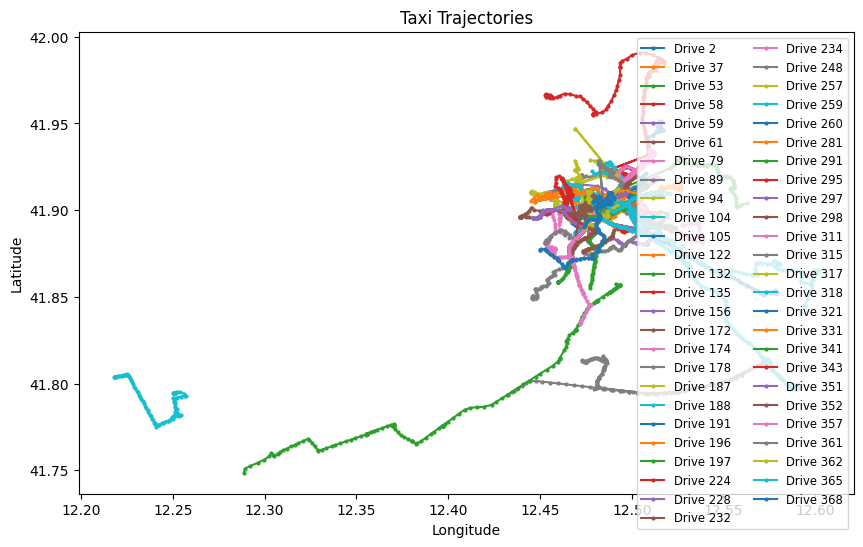

(        Unnamed: 0      DriveNo      Latitude     Longitude
 count  10000.00000  10000.00000  10000.000000  10000.000000
 mean    5000.50000    221.97690     41.894137     12.479613
 std     2886.89568    105.91888      0.028890      0.041933
 min        1.00000      2.00000     41.748570     12.217974
 25%     2500.75000    135.00000     41.891518     12.472510
 50%     5000.50000    232.00000     41.898051     12.480303
 75%     7500.25000    317.00000     41.905170     12.492777
 max    10000.00000    368.00000     41.990759     12.601874,
 Unnamed: 0       0
 DriveNo          0
 Date and Time    0
 Latitude         0
 Longitude        0
 dtype: int64)

In [ ]:
# Sort data by 'DriveNo' and 'Date and Time'
df = df.sort_values(['DriveNo', 'Date and Time']).reset_index(drop=True)

# Group by DriveNo and plot trajectories
unique_drives = df['DriveNo'].unique()
plt.figure(figsize=(10, 6))
for drive in unique_drives:
    drive_data = df[df['DriveNo'] == drive]
    plt.plot(drive_data['Longitude'], drive_data['Latitude'], marker='o', markersize=2, linestyle='-', label=f'Drive {drive}')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Taxi Trajectories')
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.show()

# Basic statistics
stats = df.describe()

# Check for missing values
missing_values = df.isnull().sum()


stats, missing_values

In [ ]:
import folium
from folium.plugins import HeatMap

# Chuyển cột thời gian về dạng datetime và sắp xếp
df['Date and Time'] = pd.to_datetime(df['Date and Time'])
df = df.sort_values(['DriveNo', 'Date and Time']).reset_index(drop=True)

# Lấy hai mốc thời gian gần nhất của mỗi chuyến đi làm điểm đón
pickup_points = df.groupby('DriveNo').head(2)[['Latitude', 'Longitude']].values

# Tạo map trung tâm ở trung bình các điểm
center_lat = df['Latitude'].mean()
center_lon = df['Longitude'].mean()
map_pickups = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Thêm các điểm đón lên bản đồ
for lat, lon in pickup_points:
    folium.CircleMarker(location=[lat, lon],
                        radius=5,
                        color='blue',
                        fill=True,
                        fill_color='blue',
                        fill_opacity=0.6).add_to(map_pickups)

# Lưu bản đồ
map_pickups.save('taxi_pickup_map.html')

In [ ]:
map_pickups

In [ ]:
# Tìm điểm đón và trả khách cho mỗi chuyến taxi
pickup_points = df.groupby('DriveNo').first()[['Latitude', 'Longitude']].reset_index()
dropoff_points = df.groupby('DriveNo').last()[['Latitude', 'Longitude']].reset_index()

# Gộp hai DataFrame để có tuyến đường
routes = pd.merge(pickup_points, dropoff_points, on='DriveNo', suffixes=('_pickup', '_dropoff'))

# Xem thử dữ liệu tuyến đường
routes.head()

,DriveNo,Latitude_pickup,Longitude_pickup,Latitude_dropoff,Longitude_dropoff
0,2,41.908130,12.504367,41.905384,12.481170
1,37,41.897842,12.468420,41.889726,12.474578
2,53,41.891202,12.502548,41.898914,12.490610
3,58,41.917559,12.513274,41.905759,12.482137
4,59,41.896783,12.482199,41.902022,12.471931


In [ ]:
# Tạo bản đồ trung tâm ở vị trí trung bình của tất cả điểm
center_lat = df['Latitude'].mean()
center_lon = df['Longitude'].mean()
map_route = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# Vẽ các tuyến đường lên bản đồ
for _, row in routes.iterrows():
    folium.PolyLine([(row['Latitude_pickup'], row['Longitude_pickup']),
                     (row['Latitude_dropoff'], row['Longitude_dropoff'])],
                    color='blue', weight=2.5, opacity=0.7).add_to(map_route)

# Lưu bản đồ
map_route.save('taxi_routes_map.html')

map_route

In [ ]:
# Xử lý dữ liệu - loại bỏ cột không cần thiết và chuyển đổi thời gian
df = df.drop(columns=['Unnamed: 0'])
df['Date and Time'] = pd.to_datetime(df['Date and Time'])

# Nhóm dữ liệu theo DriveNo để lấy từng chuyến xe riêng biệt
grouped = df.groupby('DriveNo')

# Tạo list các trajectories, mỗi xe là một trajectory (danh sách các điểm theo thời gian)
trajectories = []
for _, group in grouped:
    trajectory = group[['Longitude', 'Latitude']].values
    trajectories.append(trajectory)

len(trajectories), trajectories[:5]

(51,
 [array([[12.5043669 , 41.9081301 ],
         [12.50660092, 41.90866305],
         [12.50791146, 41.9090395 ],
         [12.50791146, 41.9090395 ],
         [12.50791146, 41.9090395 ],
         [12.50791146, 41.9090395 ],
         [12.50843366, 41.90915004],
         [12.51008975, 41.90972391],
         [12.5127348 , 41.91039609],
         [12.51396406, 41.91067809],
         [12.51396406, 41.91067809],
         [12.51439352, 41.91062753],
         [12.5158196 , 41.90954197],
         [12.51680969, 41.90831739],
         [12.51652301, 41.9079762 ],
         [12.51652301, 41.9079762 ],
         [12.51652301, 41.9079762 ],
         [12.51638867, 41.90806323],
         [12.51638867, 41.90806323],
         [12.51554406, 41.90770411],
         [12.51421257, 41.90824586],
         [12.5134954 , 41.90894774],
         [12.51170308, 41.90895001],
         [12.51067267, 41.90957134],
         [12.51065979, 41.90964639],
         [12.51065979, 41.90964639],
         [12.51065979, 41.9096463

In [16]:
import folium
from collections import Counter

In [17]:
df.columns

Index(['DriveNo', 'Date and Time', 'Latitude', 'Longitude'], dtype='object')

#Plot các tuyến đường

In [18]:
len(df['DriveNo'].unique())

51

In [19]:
colors = [
    "red", "blue", "green", "purple", "orange", "darkred", "lightred", "beige", "darkblue",
    "darkgreen", "cadetblue", "darkpurple", "pink", "gray", "black", "lightgray", "lightblue",
    "lightgreen", "lightpurple", "white", "cyan", "magenta", "lime", "gold", "maroon", "navy",
    "olive", "teal", "aqua", "fuchsia", "indigo", "khaki", "lavender", "salmon", "sienna",
    "tan", "tomato", "turquoise", "violet", "wheat", "yellow", "azure", "chartreuse", "coral",
    "crimson", "hotpink", "deepskyblue", "dodgerblue", "firebrick", "forestgreen", "goldenrod"
]

len(colors)

51

In [20]:
df["Date and Time"] = pd.to_datetime(df["Date and Time"])
taxi_colors = {}
taxi_routes = {}
start_end_points = []
for taxi_id, group in df.groupby("DriveNo"):
    group = group.sort_values("Date and Time")
    route = list(zip(group["Latitude"], group["Longitude"]))
    taxi_routes[taxi_id] = route

    if taxi_id not in taxi_colors:
        taxi_colors[taxi_id] = colors[len(taxi_colors) % len(colors)]

first_taxi_id = list(taxi_routes.keys())[0]
map_center = taxi_routes[first_taxi_id][0]

taxi_routes_map = folium.Map(location=map_center, zoom_start=12)

for taxi_id, route in taxi_routes.items():
    # Đánh dấu điểm đầu và điểm cuối của mỗi tài xế
    folium.Marker(location=route[0], popup=f"Start (Driver {taxi_id})", icon=folium.Icon(color="green")).add_to(taxi_routes_map)
    folium.Marker(location=route[-1], popup=f"End (Driver {taxi_id})", icon=folium.Icon(color="red")).add_to(taxi_routes_map)

    folium.PolyLine(
        route,
        color=taxi_colors[taxi_id],
        weight=4,
        opacity=0.8
    ).add_to(taxi_routes_map)
taxi_routes_map.save("taxi_routes.html")


In [21]:
taxi_routes_map

In [22]:
df["Date and Time"] = pd.to_datetime(df["Date and Time"])

all_latitudes, all_longitudes = [], []
taxi_routes = {}
for taxi_id, group in df.groupby("DriveNo"):
    group = group.sort_values("Date and Time")
    route = list(zip(group["Latitude"], group["Longitude"]))
    taxi_routes[taxi_id] = route

    all_latitudes.extend(group["Latitude"].tolist())
    all_longitudes.extend(group["Longitude"].tolist())

color_scale = px.colors.qualitative.Set3
taxi_colors = {}

fig = go.Figure()
for i, (taxi_id, route) in enumerate(taxi_routes.items()):
    taxi_colors[taxi_id] = color_scale[i % len(color_scale)]

    latitudes, longitudes = zip(*route)

    fig.add_trace(go.Scattermapbox(
        lat=latitudes,
        lon=longitudes,
        mode="lines",
        line=dict(width=3, color=taxi_colors[taxi_id]),
        name=f"Driver {taxi_id}"
    ))

    # Đánh dấu điểm đầu và điểm cuối
    fig.add_trace(go.Scattermapbox(
        lat=[latitudes[0], latitudes[-1]],
        lon=[longitudes[0], longitudes[-1]],
        mode="markers",
        marker=dict(size=10, color=["green", "red"]),
        name=f"Driver {taxi_id}"
    ))

# điểm đầu và điểm cuối của các tọa độ để scale lại
min_lat, max_lat = min(all_latitudes), max(all_latitudes)
min_lon, max_lon = min(all_longitudes), max(all_longitudes)

fig.update_layout(
    mapbox=dict(
        style="open-street-map",
        bounds=dict(
            west=min_lon, east=max_lon,
            south=min_lat, north=max_lat
        )
    ),
    width=1200,
    height=800,
    margin=dict(r=0, t=0, l=0, b=0),
    title="Taxi Routes"
)

fig.show()


# Plot các đoạn đường phổ biến nhất

In [23]:
# chỉ định số lượng top tuyến đường thường đi
num_top_route = 10

segment_counts = Counter()

for routes in taxi_routes.values():
    for i in range(len(routes) - 1):
        segment = (routes[i], routes[i + 1])
        segment_counts[segment] += 1

top_routes = segment_counts.most_common(num_top_route)
top_routes

[(((41.90751132, 12.49022735), (41.90751132, 12.49022735)), 66),
 (((41.79453483, 12.25077904), (41.79453483, 12.25077904)), 41),
 (((41.88971431, 12.47443066), (41.88971431, 12.47443066)), 37),
 (((41.90378371, 12.48829514), (41.90378371, 12.48829514)), 30),
 (((41.90384077, 12.4890944), (41.90384077, 12.4890944)), 28),
 (((41.895907, 12.47676859), (41.895907, 12.47676859)), 27),
 (((41.90742862, 12.49014636), (41.90742862, 12.49014636)), 26),
 (((41.89595943, 12.47682804), (41.89595943, 12.47682804)), 26),
 (((41.88973681, 12.47458953), (41.88973681, 12.47458953)), 26),
 (((41.88984834, 12.47448982), (41.88984834, 12.47448982)), 25)]

In [24]:
df["Date and Time"] = pd.to_datetime(df["Date and Time"])

all_latitudes, all_longitudes = [], []
taxi_routes = {}

for taxi_id, group in df.groupby("DriveNo"):
    group = group.sort_values("Date and Time")
    route = list(zip(group["Latitude"], group["Longitude"]))
    taxi_routes[taxi_id] = route

    all_latitudes.extend(group["Latitude"].tolist())
    all_longitudes.extend(group["Longitude"].tolist())

# chỉ định số đoạn đường top muốn lấy
num_top_routes = 10
segment_counts = Counter()

for route in taxi_routes.values():
    for i in range(len(route) - 1):
        segment = (route[i], route[i + 1])
        segment_counts[segment] += 1

top_routes = segment_counts.most_common(num_top_routes)
top_route_set = set([seg[0] for seg in top_routes])

color_scale = px.colors.qualitative.Set3
taxi_colors = {}
fig = go.Figure()

for i, (taxi_id, route) in enumerate(taxi_routes.items()):
    taxi_colors[taxi_id] = color_scale[i % len(color_scale)]
    latitudes, longitudes = zip(*route)

    line_width = 2
    line_opacity = 0.5
    for j in range(len(route) - 1):
        segment = (route[j], route[j + 1])
        if segment in top_route_set:
            line_width = 10
            line_opacity = 1

    fig.add_trace(go.Scattermapbox(
        lat=latitudes,
        lon=longitudes,
        mode="lines",
        line=dict(width=line_width, color=taxi_colors[taxi_id]),
        name=f"Driver {taxi_id}",
        opacity=line_opacity
    ))

    fig.add_trace(go.Scattermapbox(
        lat=[latitudes[0], latitudes[-1]],
        lon=[longitudes[0], longitudes[-1]],
        mode="markers",
        marker=dict(size=12, color=["green", "red"]),
        name=f"Driver {taxi_id}"
    ))

min_lat, max_lat = min(all_latitudes), max(all_latitudes)
min_lon, max_lon = min(all_longitudes), max(all_longitudes)

fig.update_layout(
    mapbox=dict(
        style="open-street-map",
        bounds=dict(
            west=min_lon, east=max_lon,
            south=min_lat, north=max_lat
        )
    ),
    width=1200,
    height=800,
    margin=dict(r=0, t=0, l=0, b=0),
    title="Taxi Routes with Highlighted Top Routes"
)

fig.show()


*Có thể thấy hầu hết các tuyến đường phổ biến tập trung ở một khu vực (khu vực trung tâm), các khu vực khác hầu như không*

# Plot những người chạy nhiều nhất và tổng số km

In [25]:
num_top_longest = 10

# Dictionary lưu chiều dài mỗi tuyến
route_lengths = {}

# Tính tổng khoảng cách cho từng tuyến đường
for taxi_id, route in taxi_routes.items():
    total_distance = sum(geodesic(route[i], route[i + 1]).km for i in range(len(route) - 1))
    route_lengths[taxi_id] = total_distance

top_longest_routes = sorted(route_lengths.items(), key=lambda x: x[1], reverse=True)[:num_top_longest]

for rank, (taxi_id, distance) in enumerate(top_longest_routes, start=1):
    print(f"{rank}. Driver {taxi_id} - {distance:.2f} km")


1. Driver 89 - 44.53 km
2. Driver 259 - 35.73 km
3. Driver 291 - 25.25 km
4. Driver 234 - 24.74 km
5. Driver 352 - 21.94 km
6. Driver 132 - 21.65 km
7. Driver 187 - 21.49 km
8. Driver 257 - 21.40 km
9. Driver 224 - 20.97 km
10. Driver 59 - 20.58 km


In [26]:
df_top_routes = pd.DataFrame(top_longest_routes, columns=["Driver", "Distance (km)"])

fig = px.bar(
    df_top_routes,
    x="Driver",
    y="Distance (km)",
    text="Distance (km)",
    labels={"Driver": "Driver ID", "Distance (km)": "Distance (km)"},
    color="Distance (km)",
    color_continuous_scale="Blues"
)

fig.update_traces(texttemplate='%{text:.2f} km', textposition='outside')
fig.update_layout(xaxis=dict(type="category"), yaxis_title="Distance (km)")

fig.show()

In [27]:
top_taxi_id = [i[0] for i in top_longest_routes]
top_taxi_id

[89, 259, 291, 234, 352, 132, 187, 257, 224, 59]

In [28]:
df["Date and Time"] = pd.to_datetime(df["Date and Time"])

all_latitudes, all_longitudes = [], []
taxi_routes = {}
for taxi_id, group in df.groupby("DriveNo"):
    group = group.sort_values("Date and Time")
    route = list(zip(group["Latitude"], group["Longitude"]))
    taxi_routes[taxi_id] = route

    all_latitudes.extend(group["Latitude"].tolist())
    all_longitudes.extend(group["Longitude"].tolist())

color_scale = px.colors.qualitative.Set3
taxi_colors = {}

fig = go.Figure()
for i, (taxi_id, route) in enumerate(taxi_routes.items()):
    taxi_colors[taxi_id] = color_scale[i % len(color_scale)]

    latitudes, longitudes = zip(*route)

    line_width = 2
    line_opacity = 0.5

    if taxi_id in top_taxi_id:
        line_width = 10
        line_opacity = 1

    fig.add_trace(go.Scattermapbox(
        lat=latitudes,
        lon=longitudes,
        mode="lines",
        line=dict(width=line_width, color=taxi_colors[taxi_id]),
        name=f"Driver {taxi_id}",
        opacity=line_opacity
    ))

    fig.add_trace(go.Scattermapbox(
        lat=[latitudes[0], latitudes[-1]],
        lon=[longitudes[0], longitudes[-1]],
        mode="markers",
        marker=dict(size=10, color=["green", "red"]),
        name=f"Driver {taxi_id}"
    ))

min_lat, max_lat = min(all_latitudes), max(all_latitudes)
min_lon, max_lon = min(all_longitudes), max(all_longitudes)

fig.update_layout(
    mapbox=dict(
        style="open-street-map",
        bounds=dict(
            west=min_lon, east=max_lon,
            south=min_lat, north=max_lat
        )
    ),
    width=1200,
    height=800,
    margin=dict(r=0, t=0, l=0, b=0),
    title="Taxi Routes"
)

fig.show()


# Tìm top các đoạn đường dài nhất nhằm kết hợp với plot phía trên đẻ xem taxi có xu hướng chọn đi các đoạn đường dài hay đi nhiều đoạn đường ngắn

In [29]:
df["Date and Time"] = pd.to_datetime(df["Date and Time"])

all_latitudes, all_longitudes = [], []
taxi_routes = {}

for taxi_id, group in df.groupby("DriveNo"):
    group = group.sort_values("Date and Time")
    route = list(zip(group["Latitude"], group["Longitude"]))
    taxi_routes[taxi_id] = route
    all_latitudes.extend(group["Latitude"].tolist())
    all_longitudes.extend(group["Longitude"].tolist())

segment_distances = {}
for route in taxi_routes.values():
    for i in range(len(route) - 1):
        segment = (route[i], route[i + 1])
        distance = geodesic(segment[0], segment[1]).km
        segment_distances[segment] = distance

# Lấy top 10 đoạn đường dài nhất
num_top_segments = 10
top_segments = sorted(segment_distances.items(), key=lambda x: x[1], reverse=True)[:num_top_segments]
top_segment_set = set(seg[0] for seg in top_segments)

In [30]:
top_segment_set

{((41.87147409, 12.46708017), (41.90225981, 12.47268825)),
 ((41.89685202, 12.48531307), (41.92832745, 12.48239609)),
 ((41.89861902, 12.5148343), (41.90036123, 12.47263076)),
 ((41.90036123, 12.47263076), (41.89861902, 12.5148343)),
 ((41.90040087, 12.4806424), (41.93260522, 12.51092066)),
 ((41.90165398, 12.47013856), (41.92416293, 12.52104158)),
 ((41.90225981, 12.47268825), (41.87147409, 12.46708017)),
 ((41.92384254, 12.48727944), (41.94694403, 12.46935061)),
 ((41.92829794, 12.48205276), (41.89685202, 12.48531307)),
 ((41.93212407, 12.51082349), (41.90040087, 12.4806424))}

In [31]:
df["Date and Time"] = pd.to_datetime(df["Date and Time"])

all_latitudes, all_longitudes = [], []
taxi_routes = {}

for taxi_id, group in df.groupby("DriveNo"):
    group = group.sort_values("Date and Time")
    route = list(zip(group["Latitude"], group["Longitude"]))
    taxi_routes[taxi_id] = route

    all_latitudes.extend(group["Latitude"].tolist())
    all_longitudes.extend(group["Longitude"].tolist())

num_top_routes = 10
segment_counts = Counter()

for route in taxi_routes.values():
    for i in range(len(route) - 1):
        segment = (route[i], route[i + 1])
        segment_counts[segment] += 1

color_scale = px.colors.qualitative.Set3
taxi_colors = {}
fig = go.Figure()

for i, (taxi_id, route) in enumerate(taxi_routes.items()):
    taxi_colors[taxi_id] = color_scale[i % len(color_scale)]
    latitudes, longitudes = zip(*route)

    line_width = 2
    line_opacity = 0.5
    for j in range(len(route) - 1):
        segment = (route[j], route[j + 1])
        if segment in top_segment_set:
            line_width = 10
            line_opacity = 1

    fig.add_trace(go.Scattermapbox(
        lat=latitudes,
        lon=longitudes,
        mode="lines",
        line=dict(width=line_width, color=taxi_colors[taxi_id]),
        name=f"Driver {taxi_id}",
        opacity=line_opacity
    ))

    fig.add_trace(go.Scattermapbox(
        lat=[latitudes[0], latitudes[-1]],
        lon=[longitudes[0], longitudes[-1]],
        mode="markers",
        marker=dict(size=12, color=["green", "red"]),
        name=f"Driver {taxi_id}"
    ))

min_lat, max_lat = min(all_latitudes), max(all_latitudes)
min_lon, max_lon = min(all_longitudes), max(all_longitudes)

fig.update_layout(
    mapbox=dict(
        style="open-street-map",
        bounds=dict(
            west=min_lon, east=max_lon,
            south=min_lat, north=max_lat
        )
    ),
    width=1200,
    height=800,
    margin=dict(r=0, t=0, l=0, b=0),
    title="Taxi Routes with Highlighted Top Routes"
)

fig.show()


*Vậy hầu hết taxi chọn đi nhiều lần tuyến đường ngắn*